In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
import math

import jax
from jax import numpy as jnp

from dm_control import suite

import dmcontrol_gridworld
import kernel_count
import tabular_density

from observation_domains import DOMAINS
import jax_specs
import utils
import replay_buffer
import point

In [3]:
env = dmcontrol_gridworld.GridWorld(20, 20)
ospec = env.observation_spec()
aspec = env.action_spec()
j_aspec = jax_specs.convert_dm_spec(aspec)

tiny_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-3, action_std_scale=1e-2)
small_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-2, action_std_scale=1e-2)
medium_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-1, action_std_scale=1e-2)
large_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e0, action_std_scale=1e-2)
tabular_count_state = tabular_density.new(ospec, aspec, state_bins=20, action_bins=4)

timestep = env.reset()
states = []
actions = []
for i in range(100):
    action = utils.sample_uniform_actions(j_aspec, jax.random.PRNGKey(i), 1)[0]
    timestep = env.step(action)
    state = utils.flatten_observation(timestep.observation)
    states.append(state)
    actions.append(action.reshape((-1,)))

states = jnp.stack(states, axis=0)
actions = jnp.stack(actions, axis=0)
tiny_kernel_count_state = kernel_count.update_batch(tiny_kernel_count_state, states, actions)
small_kernel_count_state = kernel_count.update_batch(small_kernel_count_state, states, actions)
medium_kernel_count_state = kernel_count.update_batch(medium_kernel_count_state, states, actions)
large_kernel_count_state = kernel_count.update_batch(large_kernel_count_state, states, actions)
tabular_count_state = tabular_density.update_batch(tabular_count_state, states, actions)

/home/will/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


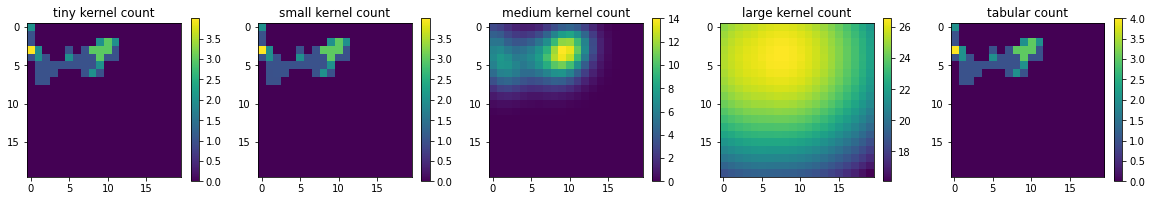

In [4]:
tiny_kernel_count_map = dmcontrol_gridworld.render_function(
        jax.partial(kernel_count.get_count_batch, tiny_kernel_count_state),
        env)
small_kernel_count_map = dmcontrol_gridworld.render_function(
        jax.partial(kernel_count.get_count_batch, small_kernel_count_state),
        env)
medium_kernel_count_map = dmcontrol_gridworld.render_function(
        jax.partial(kernel_count.get_count_batch, medium_kernel_count_state),
        env)
large_kernel_count_map = dmcontrol_gridworld.render_function(
        jax.partial(kernel_count.get_count_batch, large_kernel_count_state),
        env)
tabular_count_map = dmcontrol_gridworld.render_function(
        jax.partial(tabular_density.get_count_batch, tabular_count_state),
        env)

subfigs = [
    (tiny_kernel_count_map, "tiny kernel count"),
    (small_kernel_count_map, "small kernel count"),
    (medium_kernel_count_map, "medium kernel count"),
    (large_kernel_count_map, "large kernel count"),
    (tabular_count_map, "tabular count"),
]


fig, axs = plt.subplots(1, len(subfigs))
for ax, subfig in zip(axs, subfigs):
    render, title = subfig
    img = ax.imshow(render)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
fig.set_size_inches(4 * len(subfigs), 3)

In [5]:
utils.display_figure(fig, 'disk', 'results/kernel_heatmaps.png')

## Visualizing replays on gridworld

In [17]:
replay = replay_buffer.load(f'results/exploration/gw20_tab20x4/replay.pkl')
env = dmcontrol_gridworld.GridWorld(20, 20)
ospec = env.observation_spec()
aspec = env.action_spec()

N = 1200
states = replay.s[:N]
actions = replay.a[:N]
tiny_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-3, action_std_scale=1e-2)
tabular_count_state = tabular_density.new(ospec, aspec, state_bins=20, action_bins=4)

tiny_kernel_count_state = kernel_count.update_batch(tiny_kernel_count_state, states, actions)
tabular_count_state = tabular_density.update_batch(tabular_count_state, states, actions)

tiny_kernel_count_map = dmcontrol_gridworld.render_function(
        jax.partial(kernel_count.get_count_batch, tiny_kernel_count_state),
        env)
tabular_count_map = dmcontrol_gridworld.render_function(
        jax.partial(tabular_density.get_count_batch, tabular_count_state),
        env)

subfigs = [
    (tiny_kernel_count_map, "tiny kernel count"),
    (tabular_count_map, "tabular count"),
]


fig, axs = plt.subplots(1, len(subfigs))
for ax, subfig in zip(axs, subfigs):
    render, title = subfig
    img = ax.imshow(render)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
fig.set_size_inches(4 * len(subfigs), 3)

Growing KDE observations from 1024 to 2048.


/home/will/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


## Visualizing replays on point velocity

In [10]:
len(subfigs)

14

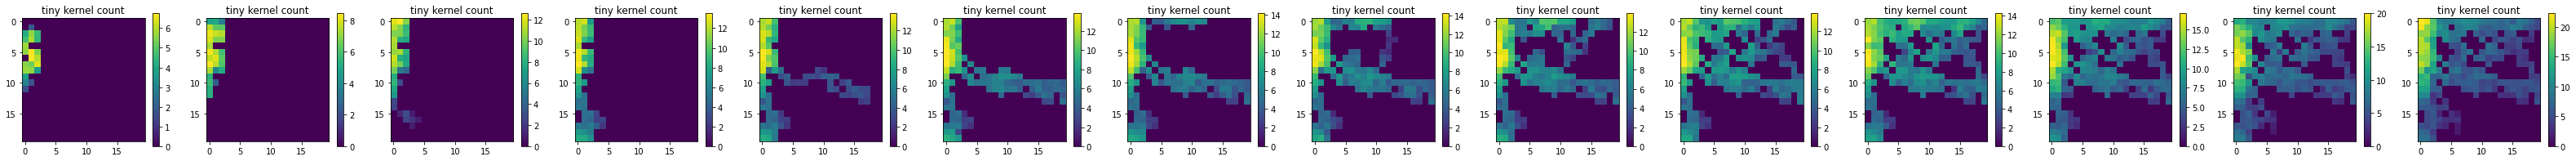

In [20]:
full_replay = replay_buffer.load(f'results/exploration/epv100kcfix_sscale0.1_ascale0.1_seed0/replay.pkl')
env = suite.load('point', 'velocity')
ospec = DOMAINS['point']['velocity']
aspec = env.action_spec()

subfigs = []
for N in range(100, 1500, 100):
    replay = replay_buffer.get_subset(full_replay, stop=N)

    states = replay.s[:N]
    actions = replay.a[:N]
    tiny_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-1, action_std_scale=1e-1)
    # tabular_count_state = tabular_density.new(ospec, aspec, state_bins=20, action_bins=2)

    tiny_kernel_count_state = kernel_count.update_batch(tiny_kernel_count_state, states, actions)
    # tabular_count_state = tabular_density.update_batch(tabular_count_state, states, actions)

    tiny_kernel_count_map = utils.render_function(
            jax.partial(kernel_count.get_count_batch, tiny_kernel_count_state),
            replay, ospec, aspec)
    # tabular_count_map = utils.render_function(
    #         jax.partial(tabular_density.get_count_batch, tabular_count_state),
    #         replay, ospec, aspec)

    subfigs.append((tiny_kernel_count_map, "tiny kernel count"))


# fig, axs = plt.subplots(3, math.ceil(len(subfigs) / 3) + 1)
fig, axs = plt.subplots(1, len(subfigs))
for ax, subfig in zip(axs, subfigs):
    render, title = subfig
    img = ax.imshow(render)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
fig.set_size_inches(4 * len(subfigs), 3)

/home/will/anaconda3/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


Growing KDE observations from 1024 to 2048.


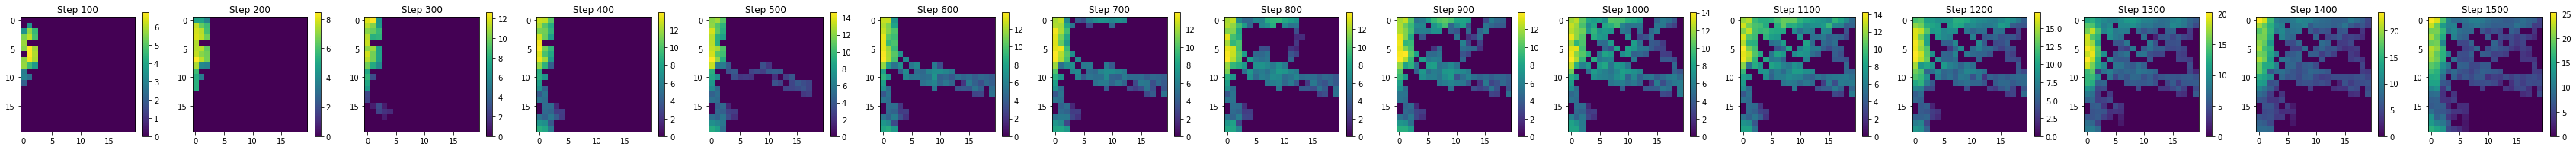

In [2]:
full_replay = replay_buffer.load(f'results/exploration/epv100kcfix_sscale0.1_ascale0.1_seed0/replay.pkl')
env = suite.load('point', 'velocity')
ospec = DOMAINS['point']['velocity']
aspec = env.action_spec()

subfigs = []
tiny_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-1, action_std_scale=1e-1)
for i in range(0, 1501):
    
#     replay = replay_buffer.get_subset(full_replay, stop=N)
    states = jnp.expand_dims(full_replay.s[i], axis=0)
    actions = jnp.expand_dims(full_replay.a[i], axis=0)
    tiny_kernel_count_state = kernel_count.update_batch(tiny_kernel_count_state, states, actions)

    if (i > 0) and (i % 100 == 0):
        tiny_kernel_count_map = utils.render_function(
            jax.partial(kernel_count.get_count_batch, tiny_kernel_count_state),
            replay_buffer.get_subset(full_replay, stop=i), 
            ospec, aspec)
        subfigs.append((tiny_kernel_count_map, f"Step {i}"))


fig, axs = plt.subplots(1, len(subfigs))
for ax, subfig in zip(axs, subfigs):
    render, title = subfig
    img = ax.imshow(render)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
fig.set_size_inches(4 * len(subfigs), 3)

Growing KDE observations from 1024 to 2048.


/home/will/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


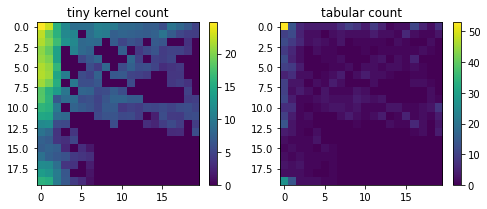

In [3]:
replay = replay_buffer.load(f'results/exploration/epv100kcfix_sscale0.1_ascale0.1_seed0/replay.pkl')
env = suite.load('point', 'velocity')
ospec = DOMAINS['point']['velocity']
aspec = env.action_spec()

N = 1500
replay = replay_buffer.get_subset(replay, stop=N)

states = replay.s[:N]
actions = replay.a[:N]
tiny_kernel_count_state = kernel_count.new(ospec, aspec, state_std_scale=1e-1, action_std_scale=1e-1)
tabular_count_state = tabular_density.new(ospec, aspec, state_bins=20, action_bins=2)

tiny_kernel_count_state = kernel_count.update_batch(tiny_kernel_count_state, states, actions)
tabular_count_state = tabular_density.update_batch(tabular_count_state, states, actions)

tiny_kernel_count_map = utils.render_function(
        jax.partial(kernel_count.get_count_batch, tiny_kernel_count_state),
        replay, ospec, aspec)
tabular_count_map = utils.render_function(
        jax.partial(tabular_density.get_count_batch, tabular_count_state),
        replay, ospec, aspec)

subfigs = [
    (tiny_kernel_count_map, "tiny kernel count"),
    (tabular_count_map, "tabular count"),
]


fig, axs = plt.subplots(1, len(subfigs))
for ax, subfig in zip(axs, subfigs):
    render, title = subfig
    img = ax.imshow(render)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
fig.set_size_inches(4 * len(subfigs), 3)

In [5]:
len(replay)

1300